# 24.1 TWFE Fundamentals: The Promise of Panel Data

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Implementation](#implementation)
4. [Numeric Demonstration](#numeric)
5. [Interview Appendix](#interview)
6. [References](#references)

---

## Learning Objectives

By the end of this notebook, you will:
- Understand why panel data enables causal inference without randomization
- Master the Two-Way Fixed Effects (TWFE) model formulation
- Implement TWFE via both dummy variables and FWL demeaning
- Estimate counterfactuals $\hat{Y}_0$ for treated units

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

from toolz import curry
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

set_notebook_style()
np.random.seed(1)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Intuition <a name="intuition"></a>

### The Power of Panel Data

**Panel data** = repeated observations of units $i$ over time periods $t$.

This structure is incredibly powerful for causal inference:

1. **Within-unit comparison**: Each unit serves as its own control (before/after)
2. **Cross-unit comparison**: Compare treated units to control units
3. **Combined**: Control for *all* time-invariant confounders (observed and unobserved)

### Cohorts and Staggered Adoption

In many applications, treatment rolls out gradually:
- **Cohort**: Group of units treated at the same time
- **Staggered adoption**: Different cohorts treated at different times
- **Never-treated**: Units that remain untreated throughout the study period

### Example: App Feature Rollout

A tech company rolls out a new feature across cities:
- Some cities get the feature on 2021-06-01
- Others get it on 2021-07-15
- The rest are control (get it after data ends)

**Question**: How many additional installs did the feature generate?

---

## 2. Formal Treatment <a name="formal"></a>

### Two-Way Fixed Effects Model

The TWFE model decomposes the outcome:

$$Y_{it} = \tau D_{it} + \gamma_i + \theta_t + \epsilon_{it}$$

where:
- $Y_{it}$: Outcome for unit $i$ at time $t$
- $D_{it}$: Treatment indicator (1 if treated, 0 otherwise)
- $\gamma_i$: **Unit fixed effect** (time-invariant unit characteristics)
- $\theta_t$: **Time fixed effect** (period-specific shocks affecting all units)
- $\tau$: Treatment effect (our estimand)

### Identification via "Holding Constant"

1. **Holding $\gamma_i$ constant**: Controls for all unit-specific, time-invariant factors
   - City population, geography, culture
   - Unobserved characteristics

2. **Holding $\theta_t$ constant**: Controls for all time-specific, unit-invariant factors
   - Macroeconomic trends
   - Seasonality
   - Industry-wide shocks

### FWL Demeaning (Computational Efficiency)

By FWL theorem, estimating TWFE with dummies is equivalent to:

$$\tilde{Y}_{it} = \tau \tilde{D}_{it} + \tilde{\epsilon}_{it}$$

where the **demeaned** variables are:

$$\tilde{Y}_{it} = Y_{it} - \underbrace{\bar{Y}_i}_{\text{unit mean}} - \underbrace{\bar{Y}_t}_{\text{time mean}} + \underbrace{\bar{Y}}_{\text{grand mean}}$$

(The grand mean is often omitted in simplified derivations)

This avoids creating $N + T$ dummy variables.

---

## 3. Implementation <a name="implementation"></a>

### Data Generating Process

We simulate an app rollout with:
- 100 cities (units)
- ~92 days (time periods)
- 3 cohorts: Early (2021-06-01), Late (2021-07-15), Never-treated (2022)
- True ATT = 1.0 (constant, instantaneous effect)

In [2]:
# Generate panel data with staggered treatment adoption
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"])
units = range(1, 100+1)

np.random.seed(1)

df = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + d["unit_fe"] + 0.1*d["time_fe"] + d["w_seas"]/10,
).assign(
    y1 = lambda d: d["y0"] + 1  # Constant treatment effect = 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

print(f"Panel dimensions: {df['unit'].nunique()} units × {df['date'].nunique()} periods")
print(f"Total observations: {len(df):,}")
print(f"\nCohort distribution:")
print(df.groupby('cohort')['unit'].nunique())

Panel dimensions: 100 units × 92 periods
Total observations: 9,200

Cohort distribution:
cohort
2021-06-01    34
2021-07-15    38
2022-01-01    28
Name: unit, dtype: int64


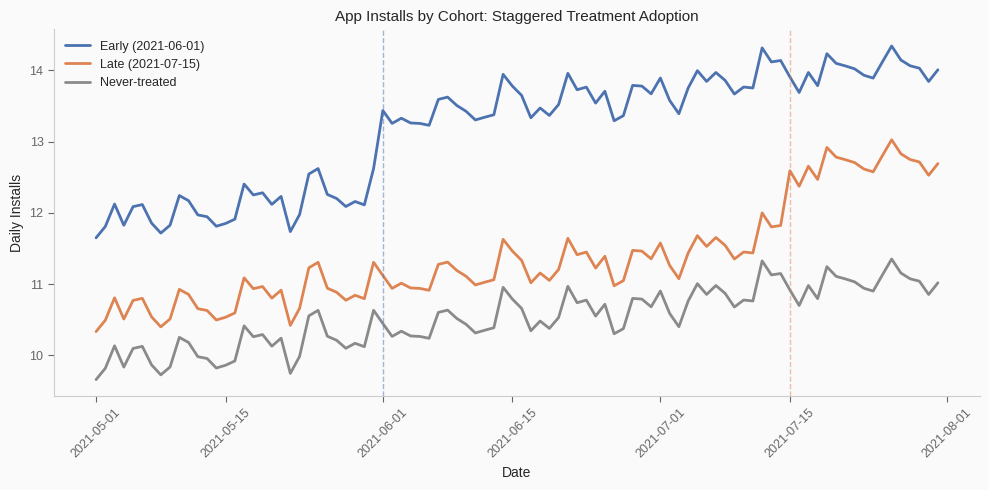

In [3]:
# Visualize the panel structure
fig, ax = create_tufte_figure(figsize=(10, 5))

# Plot cohort means
cohort_means = df.groupby(["cohort", "date"])["installs"].mean().reset_index()

colors_cohort = [COLORS['blue'], COLORS['orange'], COLORS['gray']]
cohort_labels = ['Early (2021-06-01)', 'Late (2021-07-15)', 'Never-treated']

for i, (cohort_val, color, label) in enumerate(zip(cohorts, colors_cohort, cohort_labels)):
    cohort_data = cohort_means[cohort_means['cohort'] == cohort_val]
    ax.plot(cohort_data['date'], cohort_data['installs'], 
            color=color, linewidth=2, label=label)

# Add treatment timing lines
ax.axvline(x=pd.Timestamp('2021-06-01'), color=COLORS['blue'], 
           linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(x=pd.Timestamp('2021-07-15'), color=COLORS['orange'], 
           linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel('Date')
ax.set_ylabel('Daily Installs')
ax.set_title('App Installs by Cohort: Staggered Treatment Adoption')
ax.legend(loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Key Observations

1. **Different baselines**: Cohorts have different initial install levels (unit FE)
2. **Common trend**: All cohorts follow similar upward trend (time FE)
3. **Treatment jumps**: Visible discontinuity at cohort treatment dates
4. **True effect = 1**: Clear 1-unit jump at treatment time

---

## 4. Numeric Demonstration <a name="numeric"></a>

### Method 1: TWFE with Dummies

In [4]:
# TWFE with explicit dummy variables
formula = "installs ~ treat + C(unit) + C(date)"

twfe_model = smf.ols(formula, data=df).fit()

estimated_ate = twfe_model.params["treat"]
true_ate = df.query("treat==1")["tau"].mean()

print("TWFE Results (Dummy Variables):")
print(f"  Estimated ATT: {estimated_ate:.4f}")
print(f"  True ATT:      {true_ate:.4f}")
print(f"  Bias:          {estimated_ate - true_ate:.6f}")

TWFE Results (Dummy Variables):
  Estimated ATT: 1.0000
  True ATT:      1.0000
  Bias:          0.000000


**Result**: TWFE perfectly recovers the true ATT when effects are constant over time.

### Method 2: TWFE via FWL Demeaning

In [5]:
@curry
def demean(df, col_to_demean):
    """Demean column by unit and date (FWL for two-way FE)."""
    return df.assign(**{
        col_to_demean: (
            df[col_to_demean]
            - df.groupby("unit")[col_to_demean].transform("mean")
            - df.groupby("date")[col_to_demean].transform("mean")
            + df[col_to_demean].mean()  # Add back grand mean
        )
    })

# FWL approach: demean both outcome and treatment
df_demeaned = (
    df
    .pipe(demean(col_to_demean="treat"))
    .pipe(demean(col_to_demean="installs"))
)

# Simple regression on demeaned data
fwl_model = smf.ols("installs ~ treat", data=df_demeaned).fit()

print("TWFE Results (FWL Demeaning):")
print(f"  Estimated ATT: {fwl_model.params['treat']:.4f}")
print(f"  SE:            {fwl_model.bse['treat']:.4f}")
print(f"\nVerification: Dummy method = FWL method = {np.isclose(estimated_ate, fwl_model.params['treat'])}")

TWFE Results (FWL Demeaning):
  Estimated ATT: 1.0000
  SE:            0.0000

Verification: Dummy method = FWL method = True


### Counterfactual Estimation

TWFE estimates the effect as $\hat{\tau} = Y_1 - \hat{Y}_0$, where $\hat{Y}_0$ is the counterfactual.

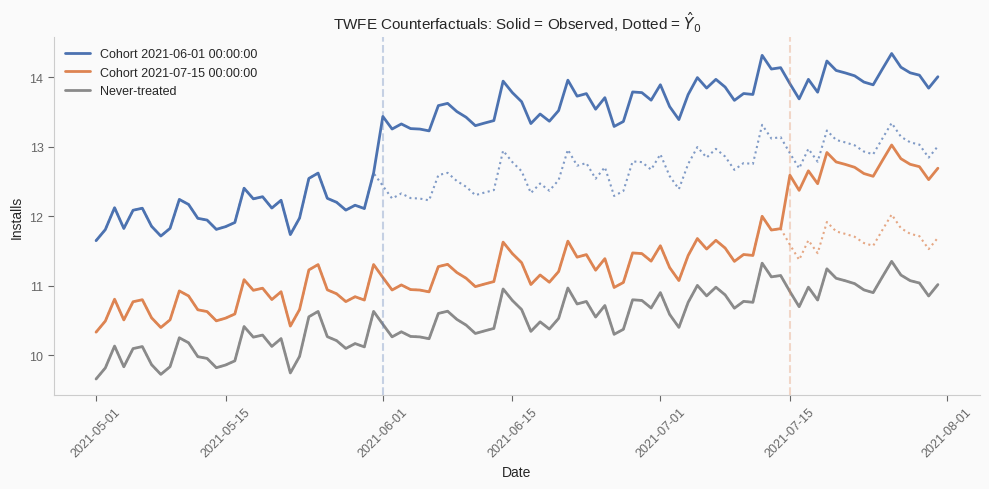

In [6]:
# Predict counterfactual Y(0) by setting treat=0 for all
df_pred = df.assign(
    installs_hat_0 = twfe_model.predict(df.assign(treat=0))
)

# Plot counterfactuals
fig, ax = create_tufte_figure(figsize=(10, 5))

# Actual outcomes
for i, (cohort_val, color) in enumerate(zip(cohorts, colors_cohort)):
    cohort_data = df_pred.groupby(["cohort", "date"])[["installs", "installs_hat_0"]].mean().reset_index()
    cohort_data = cohort_data[cohort_data['cohort'] == cohort_val]
    
    # Actual
    ax.plot(cohort_data['date'], cohort_data['installs'], 
            color=color, linewidth=2, label=f'Cohort {cohort_val}' if i < 2 else 'Never-treated')
    
    # Counterfactual (dotted)
    ax.plot(cohort_data['date'], cohort_data['installs_hat_0'], 
            color=color, linewidth=1.5, linestyle=':', alpha=0.7)

# Treatment lines
ax.axvline(x=pd.Timestamp('2021-06-01'), color=COLORS['blue'], linestyle='--', alpha=0.3)
ax.axvline(x=pd.Timestamp('2021-07-15'), color=COLORS['orange'], linestyle='--', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Installs')
ax.set_title('TWFE Counterfactuals: Solid = Observed, Dotted = $\\hat{Y}_0$')
ax.legend(loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Interpretation

The counterfactual $\hat{Y}_0$ (dotted lines) shows what TWFE predicts would have happened *without* treatment:

1. **Level adjustment**: Each cohort's counterfactual is at its baseline level
2. **Trend projection**: Common trend from control cohort is projected onto treated cohorts
3. **Effect = Gap**: The treatment effect is the gap between solid (observed) and dotted (counterfactual)

In [7]:
# Verify effect calculation
df_pred['estimated_effect'] = df_pred['installs'] - df_pred['installs_hat_0']

print("Treatment Effect by Period:")
print(f"  Pre-treatment mean effect:  {df_pred.query('treat==0')['estimated_effect'].mean():.6f}")
print(f"  Post-treatment mean effect: {df_pred.query('treat==1')['estimated_effect'].mean():.4f}")
print(f"  True ATT:                   {true_ate:.4f}")

Treatment Effect by Period:
  Pre-treatment mean effect:  0.000000
  Post-treatment mean effect: 1.0000
  True ATT:                   1.0000


---

## 5. Interview Appendix <a name="interview"></a>

### Q1: What is the Two-Way Fixed Effects model and what does it control for?

<details>
<summary>Solution</summary>

**TWFE Model**:
$$Y_{it} = \tau D_{it} + \gamma_i + \theta_t + \epsilon_{it}$$

**Controls for**:
1. **Unit fixed effects** ($\gamma_i$): All time-invariant unit characteristics (observed AND unobserved)
   - Example: City population, geography, culture
   
2. **Time fixed effects** ($\theta_t$): All unit-invariant period shocks
   - Example: Macroeconomic trends, seasonality

**Key insight**: By "holding constant" unit and time, we compare the *same unit* before/after treatment while adjusting for time trends.

**Cannot control for**: Time-varying confounders that differ across units.

</details>

### Q2: How does FWL demeaning make TWFE computationally efficient?

<details>
<summary>Solution</summary>

**Problem**: TWFE with dummies requires $N + T$ parameters (e.g., 10,000 units = 10,000+ dummies).

**FWL Solution**: Demean instead of adding dummies:
$$\tilde{Y}_{it} = Y_{it} - \bar{Y}_i - \bar{Y}_t + \bar{Y}$$

**Steps**:
1. Subtract unit mean (removes $\gamma_i$)
2. Subtract time mean (removes $\theta_t$)
3. Add grand mean (corrects double subtraction)

**Result**: Same $\hat{\tau}$ as dummy regression, but:
- O(N×T) operations instead of inverting (N+T) × (N+T) matrix
- Memory: Store means only, not dummy columns

</details>

### Q3: What assumptions does TWFE require for unbiased estimates?

<details>
<summary>Solution</summary>

**Functional Form Assumptions**:
1. **Constant effects**: Treatment effect same across units and time ($\tau_{it} = \tau$)
2. **Linearity**: Linear relationship between outcome and treatment
3. **Additive fixed effects**: $\gamma_i$ and $\theta_t$ add, not interact

**Strict Exogeneity (Independence)**:
1. **Parallel trends**: $E[Y_0(t) | D=1] - E[Y_0(t-1) | D=1] = E[Y_0(t) | D=0] - E[Y_0(t-1) | D=0]$
2. **No anticipation**: Treatment doesn't affect outcomes before it occurs
3. **No time-varying confounders**: Unobserved confounders must be time-invariant
4. **No carryover**: Past treatment doesn't affect current outcome
5. **No feedback**: Past outcome doesn't affect current treatment

**Key limitation**: If treatment effects vary over time (mature, decay), TWFE is biased.

</details>

---

## 6. References <a name="references"></a>

1. **Goodman-Bacon, A.** (2021). *Difference-in-Differences with Variation in Treatment Timing*. Journal of Econometrics.

2. **Callaway, B. & Sant'Anna, P.H.C.** (2021). *Difference-in-Differences with Multiple Time Periods*. Journal of Econometrics.

3. **Wooldridge, J.M.** (2021). *Two-Way Fixed Effects, the Two-Way Mundlak Regression, and Difference-in-Differences Estimators*. Working Paper.

4. **Facure, M.** (2022). *Causal Inference for the Brave and True*, Chapter 24.